In [1]:
import matplotlib.pyplot as plt
import numpy as np
import joblib as jb

from tensorflow import keras


from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D

from keras.engine.topology import Layer, InputSpec
from keras import backend as k

%matplotlib inline

Using TensorFlow backend.


In [2]:
# load preprocessed dragonfly images
trainpath = r'D:\Linnaeus_models\dragon\train\dragon_train.npy'
testpath = r'D:\Linnaeus_models\dragon\test\dragon_test.npy'
dragons = np.concatenate((np.load(trainpath), np.load(testpath)), axis=0)
print(f'Number of images: {len(dragons)}')

Number of images: 18407


##  Auto Encoding Using CNN

In [3]:
# separate into training set and validation set and reshape to fit the NN
x_train = dragons[0:16000] 
x_val = dragons[16000:]

In [4]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

In [ ]:
input_img = Input(shape=(256, 256, 1))

# "encoded" is the encoded representation of the input

encoded = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = MaxPool2D((2, 2), padding='same')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)

decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)

decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)

decoded = Conv2D(48, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)

decoded = Conv2D(1, (3, 3), padding='same')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.summary()

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='Adam', loss='mse')

train_history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=200, 
                                validation_data=(x_val, x_val))

In [5]:
# load the model
loaded_model = jb.load(r"D:\Linnaeus_models\dragon_reconstruction_v2.pkl")

In [6]:
train_history = loaded_model.fit(x_train, x_train, epochs=8, batch_size=100, 
                                 validation_data=(x_val, x_val))

Train on 16000 samples, validate on 2407 samples
Epoch 1/8
16000/16000 [==============================] - 3180s 199ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 2/8
16000/16000 [==============================] - 3156s 197ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 3/8
16000/16000 [==============================] - 3042s 190ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 4/8
16000/16000 [==============================] - 2934s 183ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 5/8
16000/16000 [==============================] - 2939s 184ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 6/8
16000/16000 [==============================] - 2944s 184ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 7/8
16000/16000 [==============================] - 2939s 184ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 8/8
16000/16000 [==============================] - 2955s 185ms/step - loss: 0.0086 - val_loss: 0.0082


In [7]:
preds = loaded_model.predict(x_val)

In [8]:
reverted_x = np.squeeze(x_val, axis=-1)

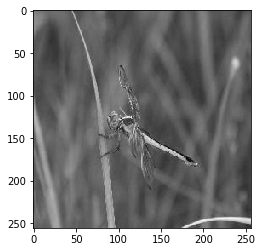

In [11]:
plt.imshow(reverted_x[12].reshape(256, 256), cmap='gray')

In [ ]:
plt.imshow(x_val[12].reshape(256, 256), cmap='gray')

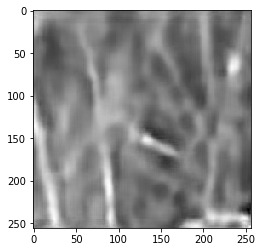

In [12]:
plt.imshow(preds[12].reshape(256, 256), cmap='gray')

In [14]:
# save model
model_path =  r'D:\Linnaeus_models\dragon_reconstruction_v3.pkl'
jb.dump(loaded_model, model_path)

['D:\\Linnaeus_models\\dragon_reconstruction_v3.pkl']

In [ ]:
# past models

In [ ]:
model_name =  r'D:\Linnaeus_models\dragon_reconstruction_v1.pkl'
new_model = jb.load(model_name)

In [ ]:
import keras
import pydot
from keras.utils import plot_model
keras.utils.vis_utils.pydot = pydot
plot_model(new_model, to_file='model.png')

In [ ]:
from keras.utils.vis_utils import model_to_dot

In [ ]:
from IPython.display import SVG
SVG(model_to_dot(new_model).create(prog='dot', format='svg'))